In [1]:
#tweetlerin veritabanından alınması
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import zemberek
import jpype,os
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
durakwords= set(stopwords.words("turkish"))
import string
import re
from typing import List
from jpype import JClass, JString, getDefaultJVMPath, shutdownJVM, startJVM, java
from scipy import stats
import seaborn as sns
from collections import Counter
from keras.models import Sequential
from keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
%matplotlib inline
df=pd.DataFrame()
df=pd.read_csv("C:/Users/user/tweets/tweets2.csv")

df

,"hash,content,class"
0,"-9223050356879576544,SON DAKİKA | Futbol Feder..."
1,"-9222573041315337832,Esen Karol Atölyesi’nin A..."
2,"-9222496288495997909,Üniversiteler ODTÜ´ye cep..."
3,"-9222480792388698410,BEŞİKTAŞ'ın yeni yapılaca..."
4,"-9222466474619073376,Cem Yılmaz yeni filminin ..."
...,...
34995,"9210072101385251033,LG Pro G2'nin bazı özellik..."
34996,"9212178017043882510,Bu marka, Twitter ve Faceb..."
34997,"9214331797304618382,Turkcell müşterileri 4G'yi..."
34998,"9216183026900103052,Facebook kullanan çocuklar..."


In [2]:
#Tweetlerin küçük harfe dönüştürülmesi
df= df.rename(columns = {'hash,content,class': 'tweets'})
df['tweets']=df['tweets'].str.lower()

In [3]:
#tweetlerin son değerlerine göre yeni bir dataframe e yerleştirilmesi
#1 tek,2 spor,eko,pol,mag,sağ,kült
#df[df.tweets.str.endswith('2')]
df['icerik']='icerik'
df['cleantext']='cleantext'
df.loc[df['tweets'].str.endswith('1'),'icerik']="teknoloji"
df.loc[df['tweets'].str.endswith('2'),'icerik']="spor"
df.loc[df['tweets'].str.endswith('3'),'icerik']="ekonomi"
df.loc[df['tweets'].str.endswith('4'),'icerik']="politika"
df.loc[df['tweets'].str.endswith('5'),'icerik']="magazin"
df.loc[df['tweets'].str.endswith('8'),'icerik']="kultur"
df.loc[df['tweets'].str.endswith('7'),'icerik']="saglik"
df.loc[df['tweets'].str.endswith('1'),'label']="1"
df.loc[df['tweets'].str.endswith('2'),'label']="2"
df.loc[df['tweets'].str.endswith('3'),'label']="3"
df.loc[df['tweets'].str.endswith('4'),'label']="4"
df.loc[df['tweets'].str.endswith('5'),'label']="5"
df.loc[df['tweets'].str.endswith('8'),'label']="8"
df.loc[df['tweets'].str.endswith('7'),'label']="7"
pd.to_numeric(df.label)

0        2
1        8
2        4
3        2
4        5
        ..
34995    1
34996    1
34997    1
34998    1
34999    1
Name: label, Length: 35000, dtype: int64

In [4]:
#Zemberek kütüphanesinin kullanılabilmesi için Jpype ile JVM oluşturulması
ZEMBEREK_PATH = r'C:\Users\user\Desktop\dersler\tweets\zemberek-full.jar'
startJVM(getDefaultJVMPath(), '-ea', '-Djava.class.path=%s' % (ZEMBEREK_PATH))
#Morphology kütüphanesini kullanacağımızdan burada oluşturuyoruz
TurkishMorphology = JClass('zemberek.morphology.TurkishMorphology')
morphology = TurkishMorphology.createWithDefaults()


In [5]:
def mentionRemove(text):
    text = re.sub(r'@\w+', '', text)#mentionların çıkartırılması
    return text

In [6]:
def siteRemove(text):
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)#bağlantıların çıkarılması
    return text

In [7]:
def puncRemove(text):
    text = re.sub('[^a-zığüşiöç\s]', '', text)#özel karakterlerin ve sayıların çıkarılması
    text = re.sub(r"Â", "A", text)#umlautlu karakterlerinn değiştirilmesi
    text = re.sub(r"â", "a", text)
    text = re.sub(r"Î", "I", text)
    text = re.sub(r"î", "ı", text)
    text = re.sub(r"Û", "U", text)
    text = re.sub(r"û", "u", text)

    return text

In [8]:
def removeSw(text):
    text=[w for w in tweet if w.lower() not in durakwords]#stopwordlerin çıkarılması
    return text

In [9]:
def rootFinder(text):
    pos=[]
    textlist=text.split(" ")
    analysis: java.util.ArrayList = ( morphology.analyzeAndDisambiguate(text).bestAnalysis() )
    for i, analysis in enumerate(analysis, start=1):
        f'\nAnalysis {i}: {analysis}',
        f'\nPrimary POS {i}: {analysis.getPos()}' 
        if (str(analysis.getLemmas()[0]) == "UNK"):
            pos.append(textlist[i-1])
        else:     
            pos.append(f'{str(analysis.getLemmas()[0])}')
    return pos


In [10]:
def emojiRemove(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

In [11]:
#hash kısmının ve sondaki içerik belirteci ve tweet bağlantısının kaldırılması
#utf-16 karakterlerin elenmesi
#kelimelerin ayrıştırılması
#tweet içerisindeki bağlantıların çıkarılması
#tweet içindeki mentionların çıkarılması
p=set(string.punctuation)

def cleaner(text):
    text=text
    text=mentionRemove(text)#mentionların çıkartırılması
    text=siteRemove(text)#bağlantıların çıkarılması
    text=puncRemove(text)#özel karakterlerin ve sayıların çıkarılması
    text=emojiRemove(text)
    text=rootFinder(text)#kelime köklerinin bulunması
    text=removeSw(text)#durak kelimelerin elenmesi
    return text


for x in range(0,len(df)):
    #tweet="ve ya da için baba veya"
    tweet=df.iloc[x,0]
    tweet=mentionRemove(tweet)#mentionların çıkartırılması
    tweet=siteRemove(tweet)#bağlantıların çıkarılması
    #tweet.replace("aracılığıyla","a")
    tweet=puncRemove(tweet)#özel karakterlerin ve sayıların çıkarılması
    tweet=rootFinder(tweet)#kelime köklerinin bulunması
    tweet=removeSw(tweet)#durak kelimelerin elenmesi
    tweet=' '.join(tweet)
    #tweet=cleaner(tweet)
    df.iloc[x,2]=tweet
    pos=[]



In [12]:
df

,tweets,icerik,cleantext,label
0,"-9223050356879576544,son daki̇ka | futbol fede...",spor,son dakika futbol federasyon tahkim kurul beşi...,2
1,"-9222573041315337832,esen karol atölyesi’nin a...",kultur,esen karol atölye ardından,8
2,"-9222496288495997909,üniversiteler odtü´ye cep...",politika,üniversite odtü cephe al aracılığıyla,4
3,"-9222480792388698410,beşi̇ktaş'ın yeni yapılac...",spor,beşiktaş yeni yap stat ilgi detay sabah spor f...,2
4,"-9222466474619073376,cem yılmaz yeni filminin ...",magazin,cem yıl yeni film başrol ver,5
...,...,...,...,...
34995,"9210072101385251033,lg pro g2'nin bazı özellik...",teknoloji,lg pro g özellik sız,1
34996,"9212178017043882510,bu marka, twitter ve faceb...",teknoloji,marka twitter facebook sol sıfır bırak,1
34997,"9214331797304618382,turkcell müşterileri 4g'yi...",teknoloji,turkcell müşteri g deneme başla,1
34998,"9216183026900103052,facebook kullanan çocuklar...",teknoloji,facebook kullan çocuk mutsuz,1


In [13]:
df.shape
df.icerik.value_counts()

magazin      5000
teknoloji    5000
kultur       5000
politika     5000
saglik       5000
ekonomi      5000
spor         5000
Name: icerik, dtype: int64

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

In [15]:
#LSTM

In [16]:
def counter_words(df):
    count = Counter()
    for i in df:
        for w in i.split():
            count[w] += 1
    return count

In [17]:
c=counter_words(df.cleantext)
MAX_NB_WORDS = int(len(c)/2)
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10
# This is fixed.
EMBEDDING_DIM = 100

In [18]:
MAX_NB_WORDS

9253

In [19]:
pd.to_numeric(df.label)
df["label"] = df["label"].astype("str").astype("int")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweets     35000 non-null  object
 1   icerik     35000 non-null  object
 2   cleantext  35000 non-null  object
 3   label      35000 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 957.2+ KB


In [49]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df.cleantext.values)
word_index=tokenizer.word_index
print(len(word_index))
tweets=df.cleantext.values
labels=df.icerik
X=tokenizer.texts_to_sequences(tweets)#word_index
X=pad_sequences(X,maxlen=MAX_SEQUENCE_LENGTH)
print('dsa',X.shape)
dummyY = pd.get_dummies(df.icerik)
Y=dummyY.values
print('Shape of label tensor:', Y.shape)
#test_text=tokenizer.texts_to_sequences(test_text)
#test_padded = pad_sequences(test_text,maxlen=max_len,padding = 'post',truncating="post")

18507
dsa (35000, 10)
Shape of label tensor: (35000, 7)


In [50]:
Ycolumns=[]
for i in dummyY.columns:
    Ycolumns.append(i)
Ycolumns
print(X.shape[1])

10


In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 44)
actual=Y_test
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)
print(X_train[15])
print(Y_train[15])

(24500, 10) (24500, 7)
(10500, 10) (10500, 7)
[   0 1035 1195   92   83  996   18 1664 2366 3666]
[0 0 1 0 0 0 0]


In [43]:

from tensorflow.keras import regularizers
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1],embeddings_regularizer=regularizers.l2(0.0001)))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64
model.summary()
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 100)           925300    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 10, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total params: 1,006,407
Trainable params: 1,006,407
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


345/345 [==============================] - 6s 19ms/step - loss: 1.0988 - accuracy: 0.6052 - val_loss: 0.7526 - val_accuracy: 0.7686
Epoch 2/5
345/345 [==============================] - 6s 17ms/step - loss: 0.5847 - accuracy: 0.8249 - val_loss: 0.7176 - val_accuracy: 0.7865
Epoch 3/5
345/345 [==============================] - 6s 17ms/step - loss: 0.4650 - accuracy: 0.8715 - val_loss: 0.7198 - val_accuracy: 0.7922
Epoch 4/5
345/345 [==============================] - 6s 17ms/step - loss: 0.3950 - accuracy: 0.8984 - val_loss: 0.7645 - val_accuracy: 0.7939
Epoch 5/5
345/345 [==============================] - 6s 17ms/step - loss: 0.3640 - accuracy: 0.9080 - val_loss: 0.7792 - val_accuracy: 0.7906


In [44]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

329/329 [==============================] - 1s 2ms/step - loss: 0.7408 - accuracy: 0.7974
Test set
  Loss: 0.741
  Accuracy: 0.797


In [39]:
new_complaint = ['google mühendis ilk özellik']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']
print(pred, labels[np.argmax(pred)])

[[0.13727131 0.0653856  0.04908493 0.00595347 0.05280714 0.09043042
  0.59906715]] teknoloji


In [ ]:
reverse_word_index=dict([(value,key) for (key,value) in word_index.items()])
def decode(text):
    return " ".join([reverse_word_index.get(i,"?") for i in text])


In [ ]:
###predict a df item
x=1#index 366 wrong-labeled
item=X_test[x]
item = [char for char in item]
arr=np.array([])
arr=arr.tolist()
arr.append(item)
arr.append(arr) 
arr=arr.pop()
arr=np.array(arr)
arr=pad_sequences(arr,maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(arr)
labels = ['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']
print("the input tweet is: ",decode(X_test[x]))
print(pred, "\npredicted class is :",labels[np.argmax(pred)])
print("actual class is :",labels[np.argmax(Y_test[x])])

In [84]:
preds=model.predict(X_test).argmax(axis=1)
le=LabelEncoder()
pred=le.fit_transform(preds)
#print(pred)
pred=np.asarray(tf.keras.utils.to_categorical(pred))
print(classification_report(pred.argmax(axis=1), actual.argmax(axis=1),target_names=['ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji']))
print("accuracy score is",accuracy_score(actual,pred))

              precision    recall  f1-score   support

     ekonomi       0.75      0.80      0.77      1410
      kultur       0.77      0.75      0.76      1603
     magazin       0.75      0.73      0.74      1506
    politika       0.78      0.84      0.81      1371
      saglik       0.85      0.81      0.83      1582
        spor       0.86      0.91      0.88      1394
   teknoloji       0.86      0.81      0.83      1634

    accuracy                           0.80     10500
   macro avg       0.80      0.81      0.80     10500
weighted avg       0.80      0.80      0.80     10500

accuracy score is 0.803047619047619


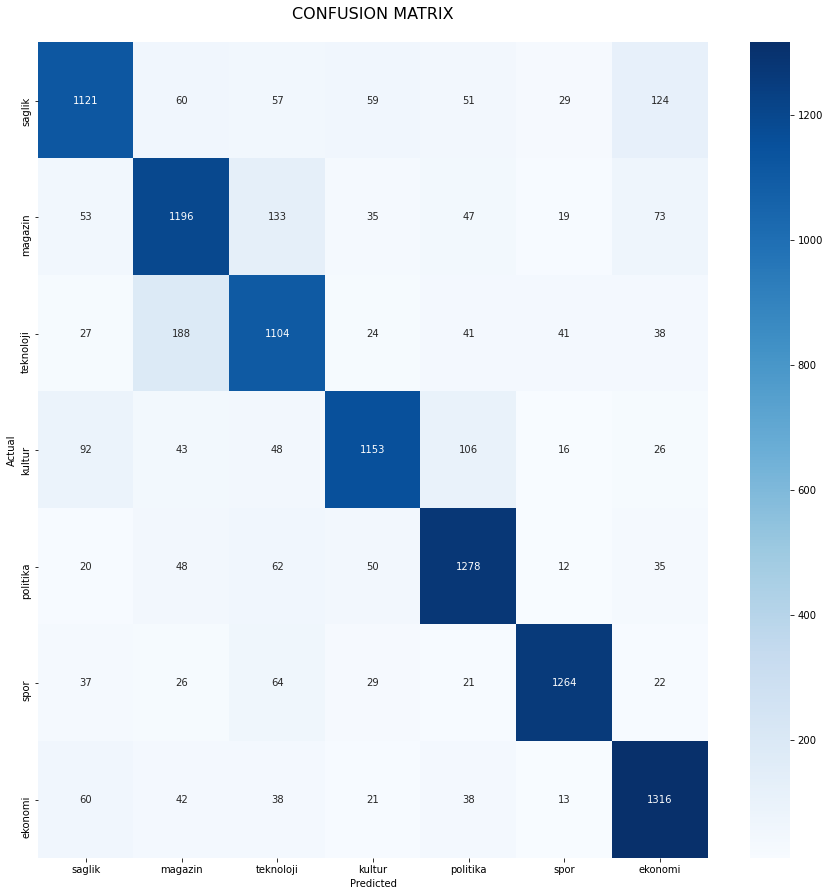

In [85]:
conf_mat = confusion_matrix( actual.argmax(axis=1),pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'},
            yticklabels={'ekonomi', 'kultur', 'magazin', 'politika', 'saglik', 'spor', 'teknoloji'})
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=16);

In [ ]:
# shutdownJVM()